# Autoregressive Models: Prediction for Gasoline Price

**Objective:** In this project, my aim is to create an autoregressive (AR) model to predict the weekly retail price for Gasoline per Gallon in the US. The dataset is given here https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_nus_dpg&f=w. It contains prices ($) of gasoline from every week dating back to April of 1993.

We will start by importing the necessary libraries.

In [160]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
import seaborn as sns





In [161]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

**Task 1:** Create a function named wrangle. Passing a filename to it will return a dataframe where date is an index column. Set the date column as 'datetime64' data type. Then localize the timezone for Denver, USA. Remove the price where it crossed 4.5 dollars. Take the mean during resampling to week. Forward fill any missing values. Since, there is only one observation, price. So, it's more appropriate to keep it as a series.

In [102]:
def wrangle(filepath):
    
    # Import the file and set the date as index
    df =pd.read_csv(filepath).set_index("date")
    
    # Convert the date column as datetime type
    df.index = pd.to_datetime(df.index)
    
    # localize time zone
    df.index = df.index.tz_localize("UTC").tz_convert("America/Denver")
    
    # Only include weeks when the price was less than 4.5 dollars
    mask = df["price_usd"] < 4.5
    df = df[mask]
    
   
    # Resample to 1W window, forward fill missing values
    y = df["price_usd"].resample("1W").mean().fillna(method = 'ffill')
    

    
    return y


In [103]:
y = wrangle('Gasoline Prices.csv')
print(y.shape)
y.tail()


(1578,)


date
2023-05-28 00:00:00-06:00    3.684
2023-06-04 00:00:00-06:00    3.655
2023-06-11 00:00:00-06:00    3.707
2023-06-18 00:00:00-06:00    3.690
2023-06-25 00:00:00-06:00    3.685
Freq: W-SUN, Name: price_usd, dtype: float64

In [104]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1578 entries, 1993-04-04 00:00:00-07:00 to 2023-06-25 00:00:00-06:00
Freq: W-SUN
Series name: price_usd
Non-Null Count  Dtype  
--------------  -----  
1578 non-null   float64
dtypes: float64(1)
memory usage: 24.7 KB


**Task 2:** Do we have null values? What's the data type anyway. Let's check those

In [105]:
print (y.isnull().sum())
print (type(y))

0
<class 'pandas.core.series.Series'>


It is a pandas series, and there are no null values

**Task 3:** Visualize the distribution of Price with a boxplot. Set a title and a label for x axis accordingly.

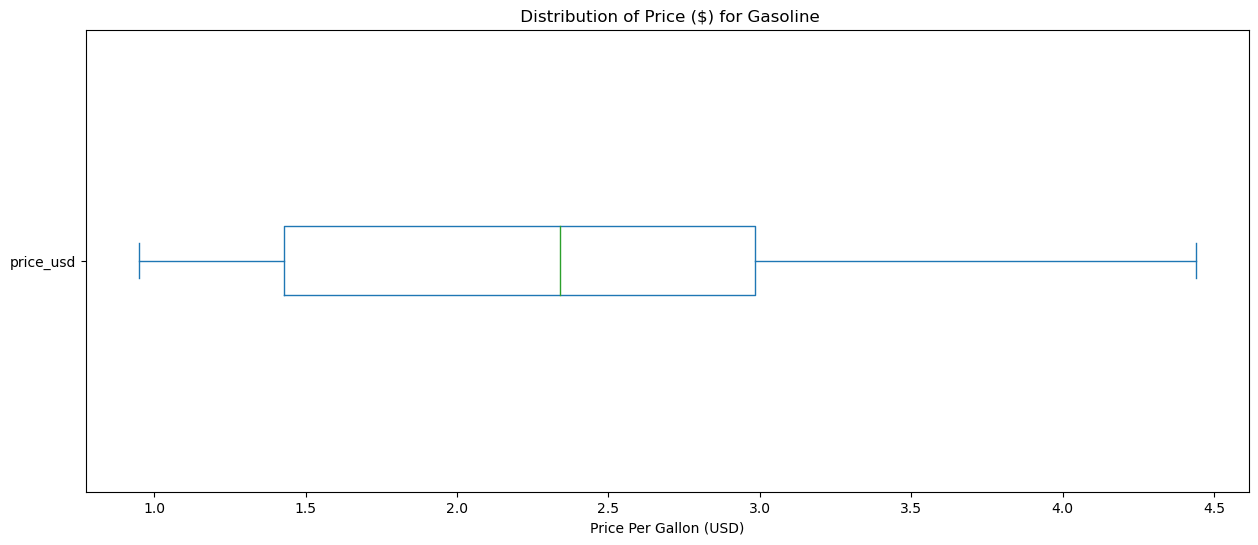

In [106]:
# Creating a boxplot to locate outliers
fig, ax = plt.subplots(figsize=(15,6))
y.plot(kind = "box", vert=False, title= " Distribution of Price ($) for Gasoline", ax=ax)
ax.set_xlabel("Price Per Gallon (USD)");

**Task 4:** Create another table to see the distribution 

In [107]:
y.describe()

count    1578.000000
mean        2.319647
std         0.934153
min         0.949000
25%         1.428250
50%         2.341000
75%         2.983750
max         4.440000
Name: price_usd, dtype: float64

**Task 5:** Create a time series plot for the gas price

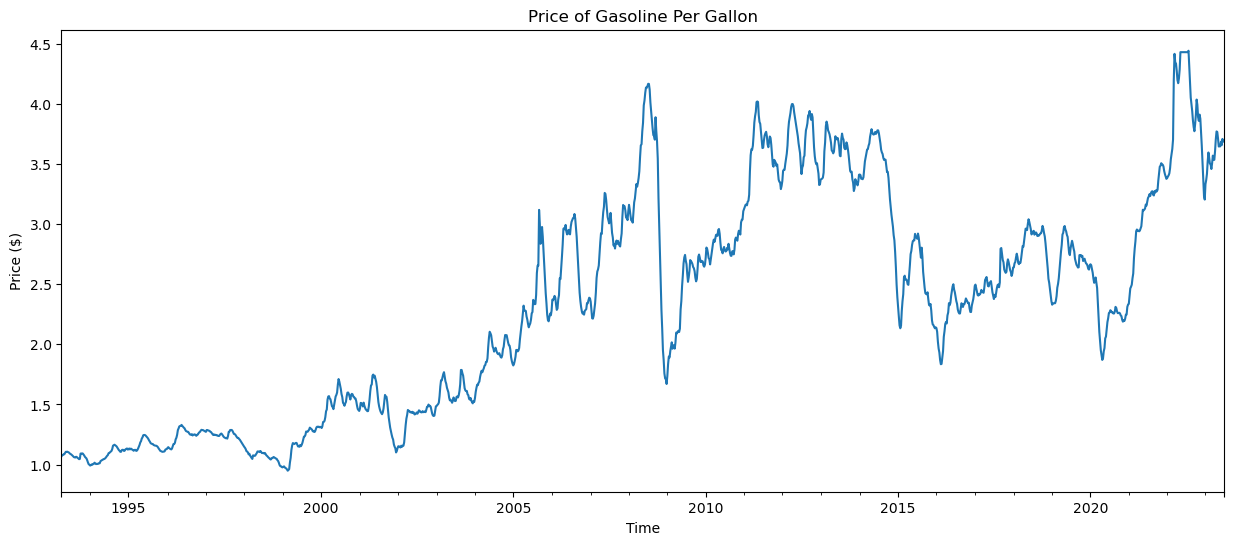

In [108]:
#Creating a time series plot of the Price
fig, ax =plt.subplots(figsize = (15,6))
y.plot(xlabel= "Time", ylabel = "Price ($)", title= "Price of Gasoline Per Gallon", ax=ax);

**Task 6:** Let's create a smoother plot with a rolling average. We set it to 52 becuase we want to visualize the data by year. and 52 is the number of weeks in a year.

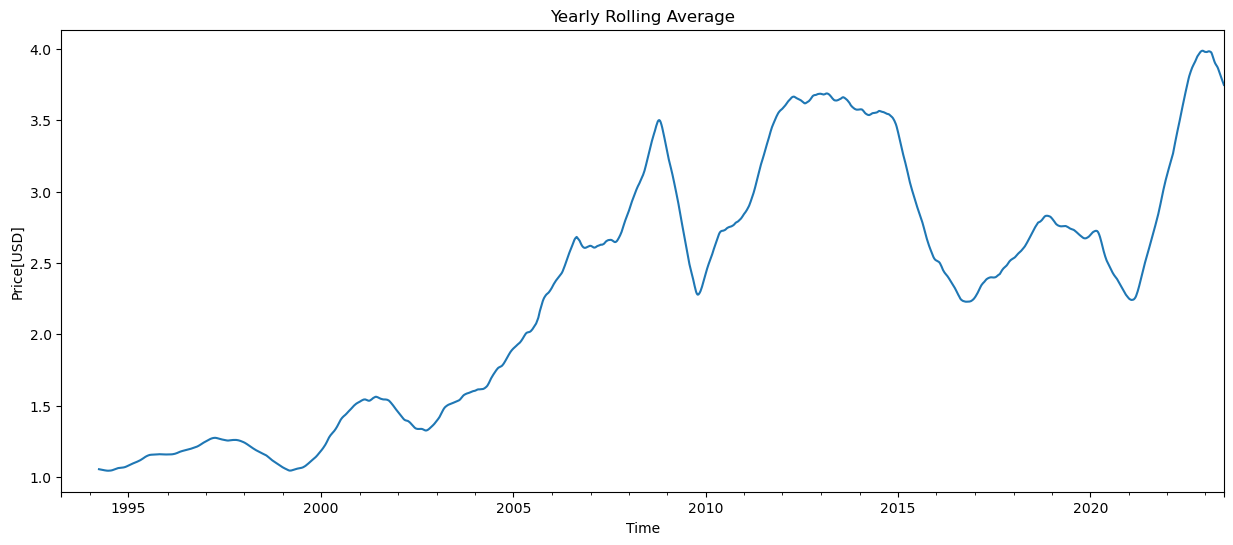

In [109]:
#Creating a time series plot of the Price with a rolling average
fig, ax =plt.subplots(figsize = (15,6))
y.rolling(52).mean().plot(xlabel= "Time", ylabel = "Price[USD]", title= "Yearly Rolling Average", ax=ax);

In [110]:
y.corr(y.shift(1))

0.9985654247457315

In [111]:
y.corr(y.shift(5))

0.9814945028709428

In [112]:
y.corr(y.shift(19))

0.9047283648412229

In [113]:
y.corr(y.shift(30))

0.8651833333653521

In [114]:
y.corr(y.shift(35))

0.8566757477902537

**Task 7:** How many lags should we add in our AR model? We will determine that from Partial Autocorrelation Function (PACF) plot. But first we want to plot an ACF plot. It will show us how past information (prices of gas in the past weeks) is related to the present information.

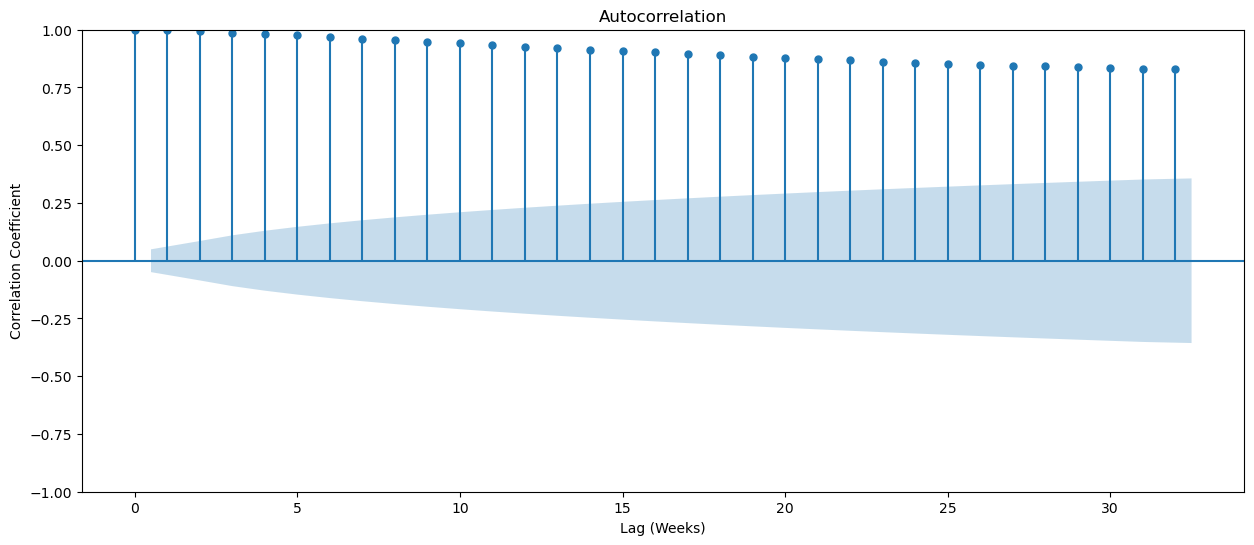

In [115]:
#Create an ACF plot
fig,ax = plt.subplots(figsize = (15,6))
plot_acf(y, ax=ax)

plt.xlabel("Lag (Weeks)")
plt.ylabel("Correlation Coefficient");


It seems the price of the gas in the current week is strongly correlated to the price even thirty weeks ago.

In [116]:
y.shift(23).corr(y.shift(24))

0.998546086308053

The one week echo is there. A PACF plot will remove this echo and show us how many lags are actually valuable for us.

**Task 8:** plot a PACF plot

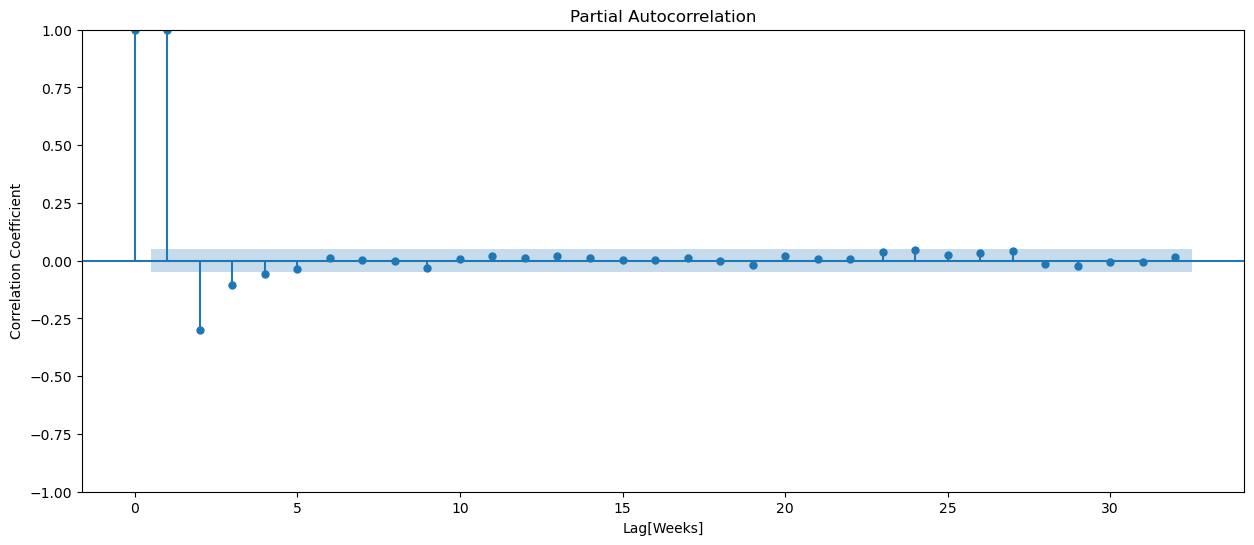

In [117]:
#Create a PACF plot
fig,ax = plt.subplots(figsize = (15,6))
plot_pacf(y, method = 'ywm', ax=ax) 
plt.xlabel("Lag[Weeks]")
plt.ylabel("Correlation Coefficient");

From the above PACF plot, it is seen that there is no predictive power after the fourth lag. It means the price of the gas in the current week has a strong correlation with the price a month ago.


**Task 9:** Split the data horizontally. Take 10% of the data for test set.

In [118]:
cutoff = int(len(y) * 0.90)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]


**Task 10:** Double checking the length of the two sets equals to the length of the original series

In [119]:
len(y_train) + len(y_test) == len(y)

True

**Task 11:** Build a Baseline Model. Determine the mean absolute error (MAE).

In [120]:
#Build a Baseline Model
y_train_mean = y_train.mean()
y_train_pred = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_train_pred)
print("Mean Weekly Price:", round(y_train_mean,2))
print("Error of the Baseline Model (MAE):", round(mae_baseline,2))


Mean Weekly Price: 2.21
Error of the Baseline Model (MAE): 0.78


It means we are off by 78 cents when we predict weekly gasoline price per gallon. We have to beat it in our AR model.

**Task 12:** Instantiate an AutoReg model and fit the model on training set. Set the lags equals to 4.

In [121]:
model = AutoReg(y_train, lags = 4).fit()

See the predictions on the training data

In [122]:
model.predict()

date
1993-04-04 00:00:00-07:00         NaN
1993-04-11 00:00:00-06:00         NaN
1993-04-18 00:00:00-06:00         NaN
1993-04-25 00:00:00-06:00         NaN
1993-05-02 00:00:00-06:00    1.094171
                               ...   
2020-05-17 00:00:00-06:00    1.968230
2020-05-24 00:00:00-06:00    1.987320
2020-05-31 00:00:00-06:00    2.097162
2020-06-07 00:00:00-06:00    2.077521
2020-06-14 00:00:00-06:00    2.161967
Freq: W-SUN, Length: 1420, dtype: float64

The first four are null values, becuase it needs to see the price of four previous weeks before it makes the prediction. So we need to drop these four observations.

**Task 13:** Predict the price on the training set and calculate the mean absolute error. In order to calculate the MAE, both of the sets, y_pred and y_train have to be equal in size. But we dropped four values from the prediction set. Therefore, from the training set, start with the index 4 and go all the way.  

In [123]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[4:], y_pred)
print("Error on Training Set (MAE):", round(training_mae, 4))

Error on Training Set (MAE): 0.0249


For any linear model, we need to check the residuals; which is the difference between a true value versus a predicted value. The distribution of the residuals should look like a perfect bell curve. So before jumping in to test the model on the test set, let's see the distribution of residual of our model.

**Task 14:** Use y_train and y_pred to calculate the residual of your model

In [124]:
y_train_resid = y_train - y_pred
y_train_resid.tail(5)

date
2020-05-17 00:00:00-06:00    0.000770
2020-05-24 00:00:00-06:00    0.061680
2020-05-31 00:00:00-06:00   -0.033162
2020-06-07 00:00:00-06:00    0.045479
2020-06-14 00:00:00-06:00    0.023033
Freq: W-SUN, dtype: float64

the same thing can be calculated with the function from statsmodels package

In [125]:
y_train_resid = model.resid

**Task 15:** Plot a time series graph for the residuals

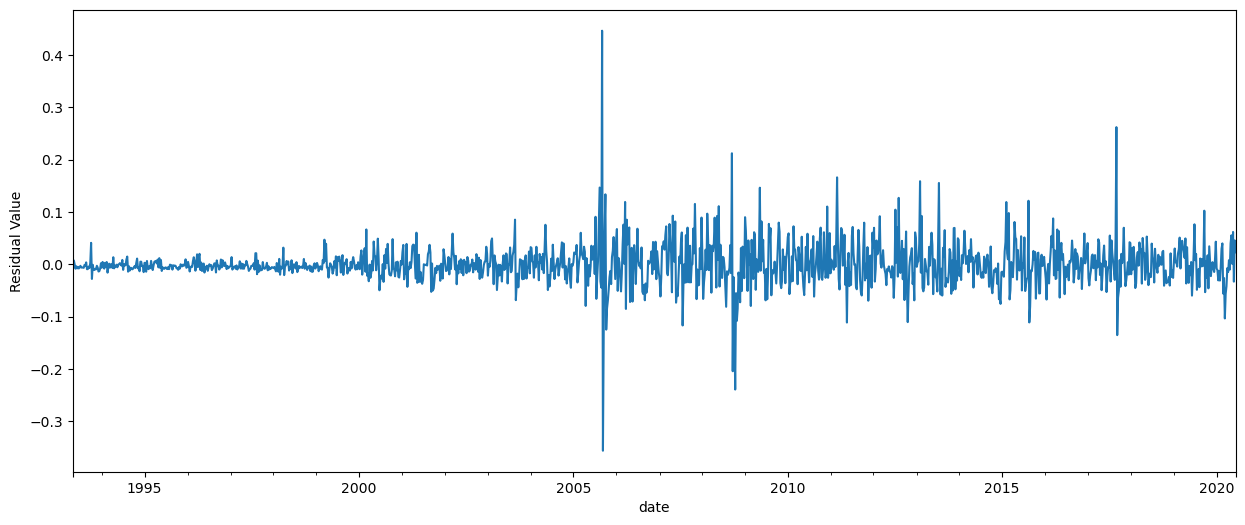

In [126]:
#plotting the residual
fig,ax =plt.subplots(figsize = (15,6))
y_train_resid.plot(ylabel="Residual Value", ax=ax);

That's what you want to see in a time series plot for a residual, centered around zero.

**Task 16:** Create a histogram of y_train_resid

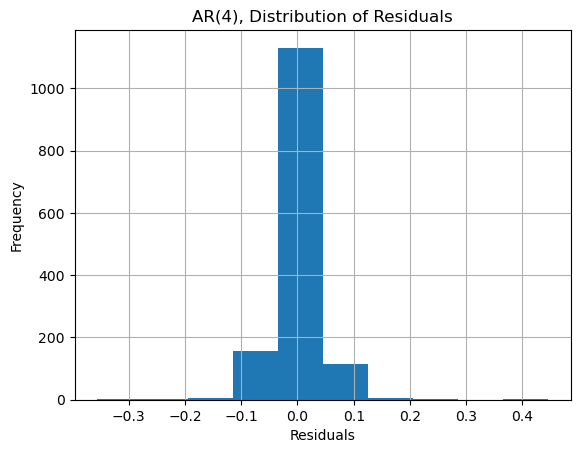

In [127]:
#Plotting the histogram
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("AR(4), Distribution of Residuals");

**Task 17:** Plot an ACF plot for the residuals

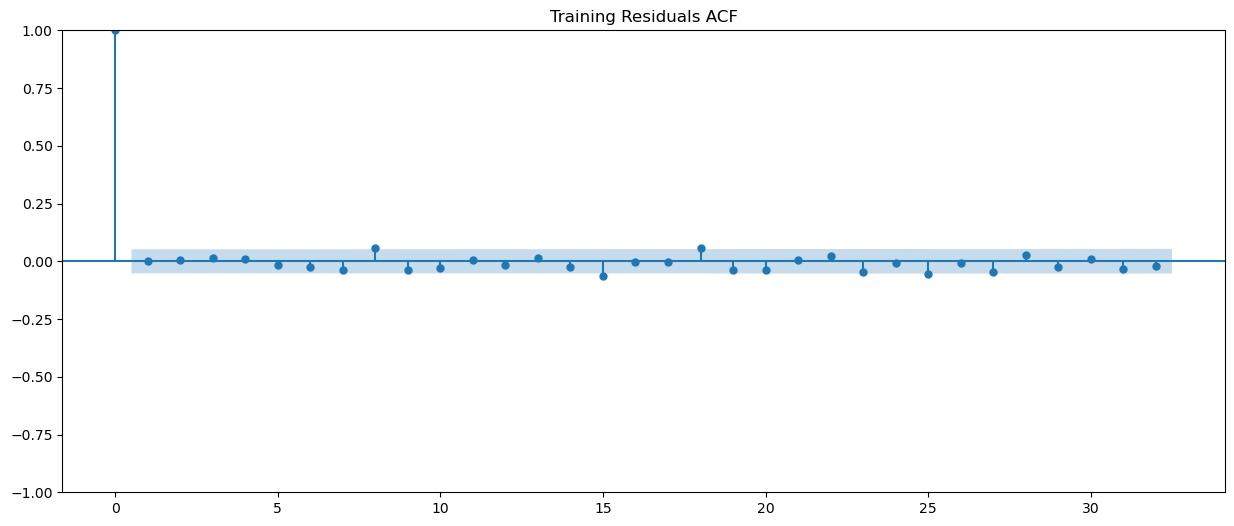

In [128]:
#ACF plot of the residual
fig,ax = plt.subplots(figsize=(15,6))
plot_acf(y_train_resid, ax=ax)
plt.title("Training Residuals ACF");

That's what we want to see in an ACF plot of the residuals; no predictive power. 

In [129]:
y_test.tail()

date
2023-05-28 00:00:00-06:00    3.684
2023-06-04 00:00:00-06:00    3.655
2023-06-11 00:00:00-06:00    3.707
2023-06-18 00:00:00-06:00    3.690
2023-06-25 00:00:00-06:00    3.685
Freq: W-SUN, Name: price_usd, dtype: float64

In [130]:
y_test.index.min()

Timestamp('2020-06-21 00:00:00-0600', tz='America/Denver', freq='W-SUN')

In [131]:
y_test.index.max()

Timestamp('2023-06-25 00:00:00-0600', tz='America/Denver', freq='W-SUN')

Let's create predictions for the test set 

**Task 18:** Create predictions for test set

In [132]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
y_pred_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", y_pred_mae)

Test MAE: 1.0201884075187424


See, That's not even beating the baseline! we are off by more than a dollar. Let's plot it and see what's happening. It means our model is not generalizing well.

**Task 19:** Create a dataframe from a dictionary. The dictionary has the predicted datapoints and datapoints from the test set. 

In [133]:
df_pred_test = pd.DataFrame(
{"y_test": y_test, "y_pred" : y_pred_test} , index = y_test.index
)    

In [134]:
df_pred_test.tail()

,y_test,y_pred
date,,
2023-05-28 00:00:00-06:00,3.684,2.320815
2023-06-04 00:00:00-06:00,3.655,2.320805
2023-06-11 00:00:00-06:00,3.707,2.320796
2023-06-18 00:00:00-06:00,3.690,2.320787
2023-06-25 00:00:00-06:00,3.685,2.320777


**Task 20:** Create a time series plot with a seaborn line plot for the values in df_pred_test. Label the axis as "Price ($)"

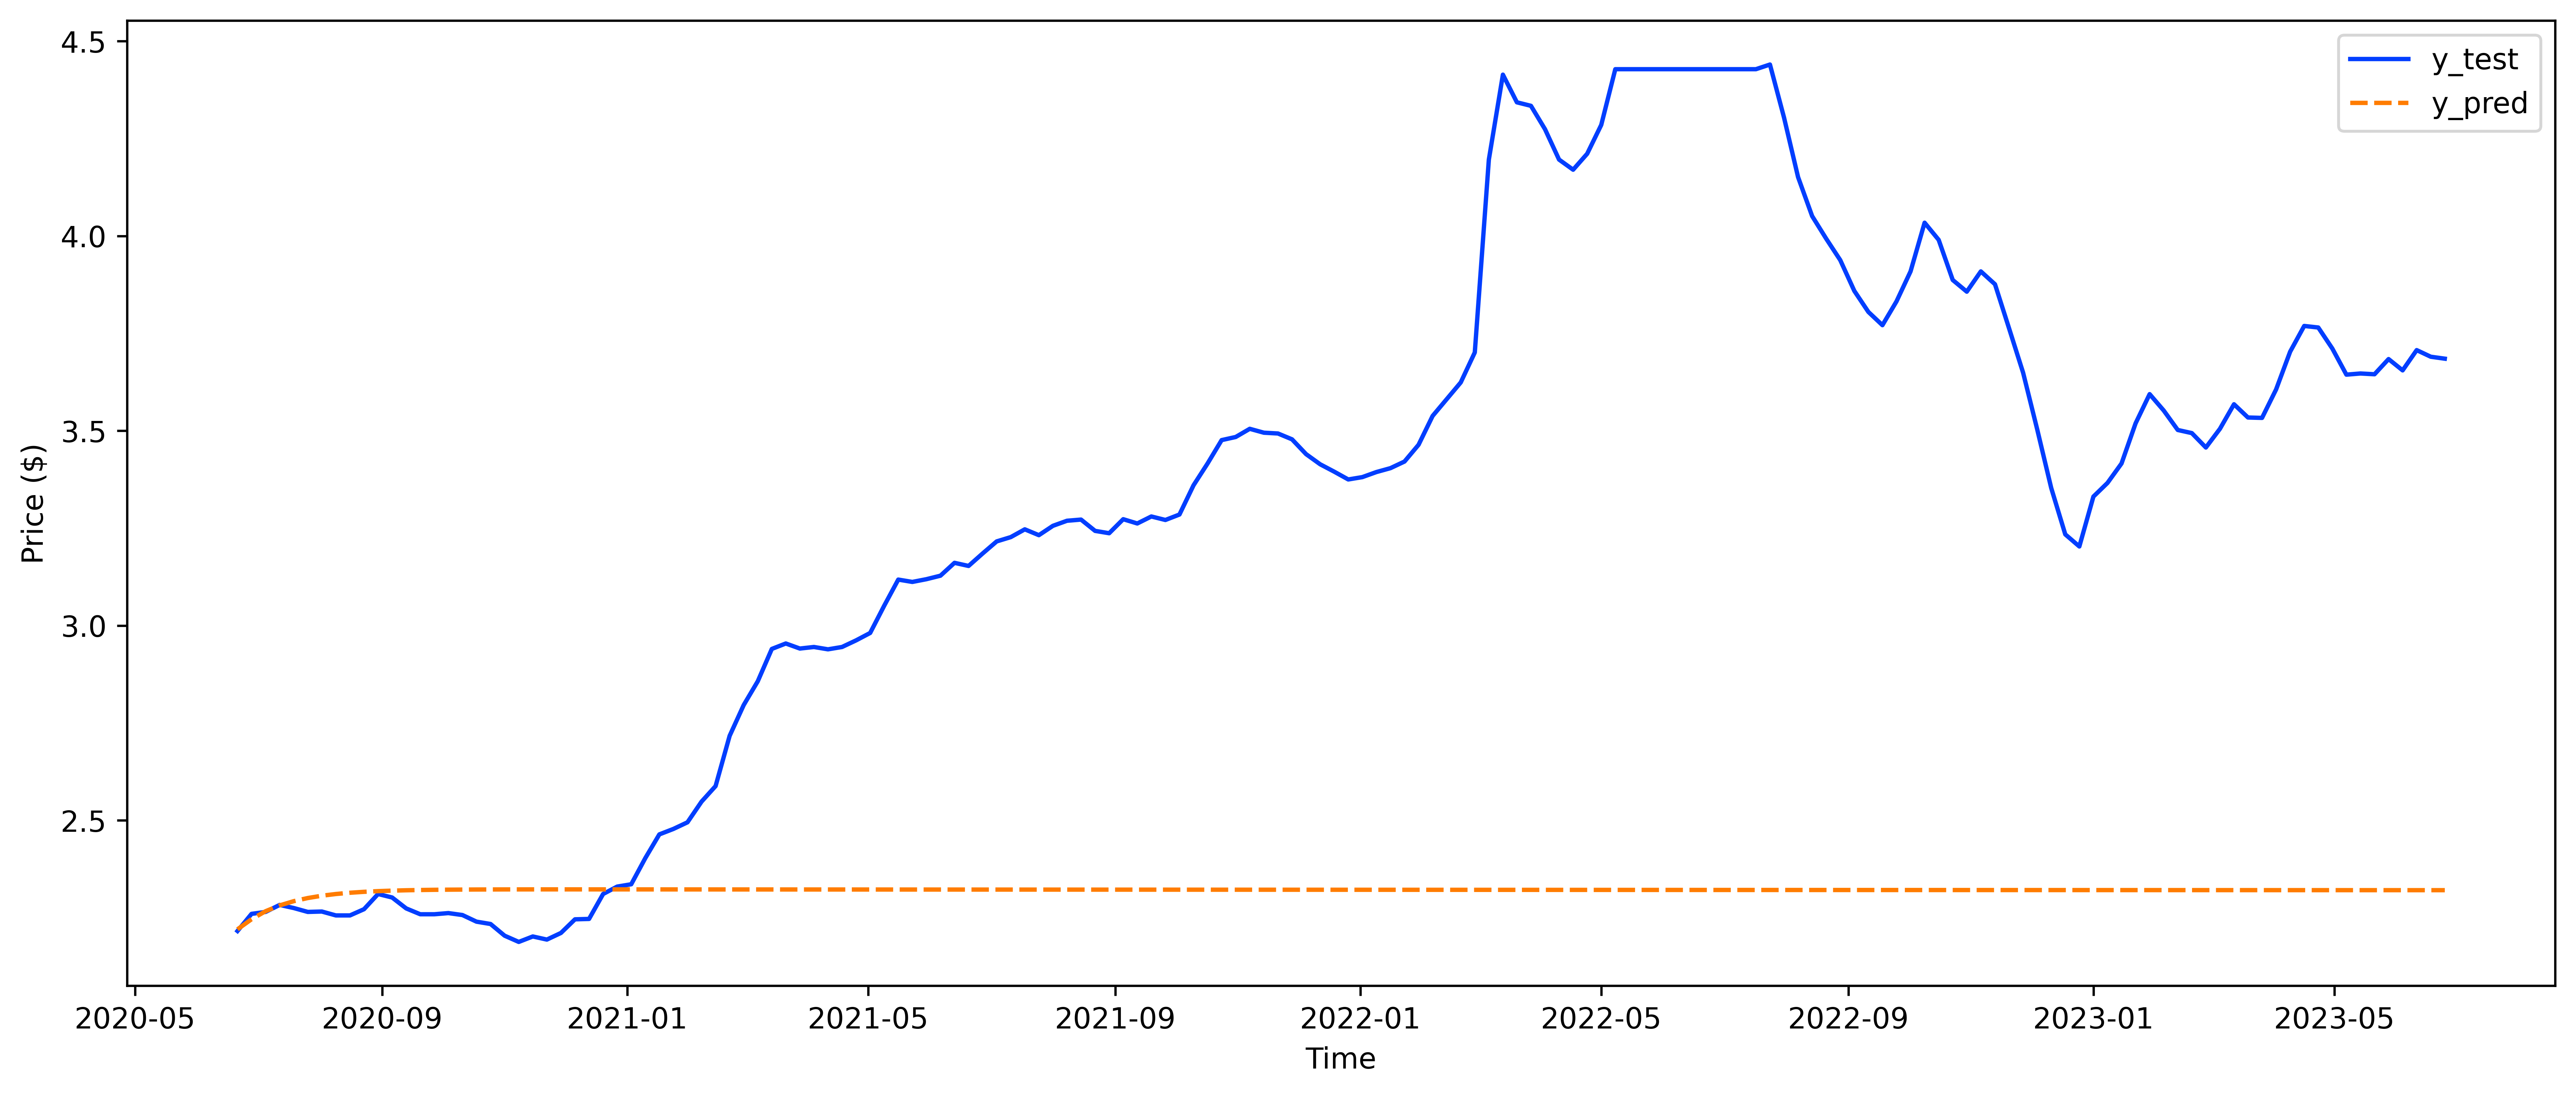

In [159]:
fig, ax =plt.subplots(dpi = 600, figsize = (15,6))
sns.lineplot(data =df_pred_test, palette = 'bright')
plt.xlabel("Time")
plt.ylabel("Price ($)");


That's a poor prediction. Why was the model unable to generalize for the test set? When evaluating time series data, one possible solution for this kind of problem is walk-forward validation (WFV), also known as out-of-sample prediction. In WFV, we begin with the training data and make a prediction for the first data point of the test set. Then, we include this first data point from the test set in our training data and make a prediction for the second data point of the test set. We continue this process, including each new data point in our training set, until we have predicted values for all the data points in our test set. We calculate the Mean Absolute Error (MAE) by comparing the actual values (y_test) with the predicted values (y_pred_wfv).

**Task 21:** Perform Walk-Forward validation for the model for the whole test set y_test. Store model's prediction in the series y_pred_wfv

In [136]:
y_pred_wfv = pd.Series()  # store our predictions
history = y_train.copy()  # starts with training data, we will keep adding data points from our test set one-by-one
for i in range(len(y_test)):
    model = AutoReg(history, lags = 4).fit()
    next_pred = model.forecast() # create out of sample prediction
    y_pred_wfv = y_pred_wfv.append(next_pred) # appending to a series is little different than appending to a list
    history = history.append(y_test[next_pred.index]) # append the datapoint with the same index as next_pred

**Task 22:** Find MAE for y_pred_wfv

In [137]:
# finding mae
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (WALK FORWARD VALIDATION): ", round (test_mae, 4))

Test MAE (WALK FORWARD VALIDATION):  0.0349


**Task 21:** Print the model parameters for the trained model

In [138]:
print(model.params)

const           0.006425
price_usd.L1    1.534977
price_usd.L2   -0.553858
price_usd.L3    0.109560
price_usd.L4   -0.093178
dtype: float64


**Task 22:** Put the values for y_test and and y_pred_wfv into a dictionary df_pred_test. Turn it into a dataframe and plot it's values with a seaborn lineplot.

In [155]:
df_pred_wfv_test = pd.DataFrame(
         {"y_test": y_test, "y_pred_wfv": y_pred_wfv} , index=y_test.index
)

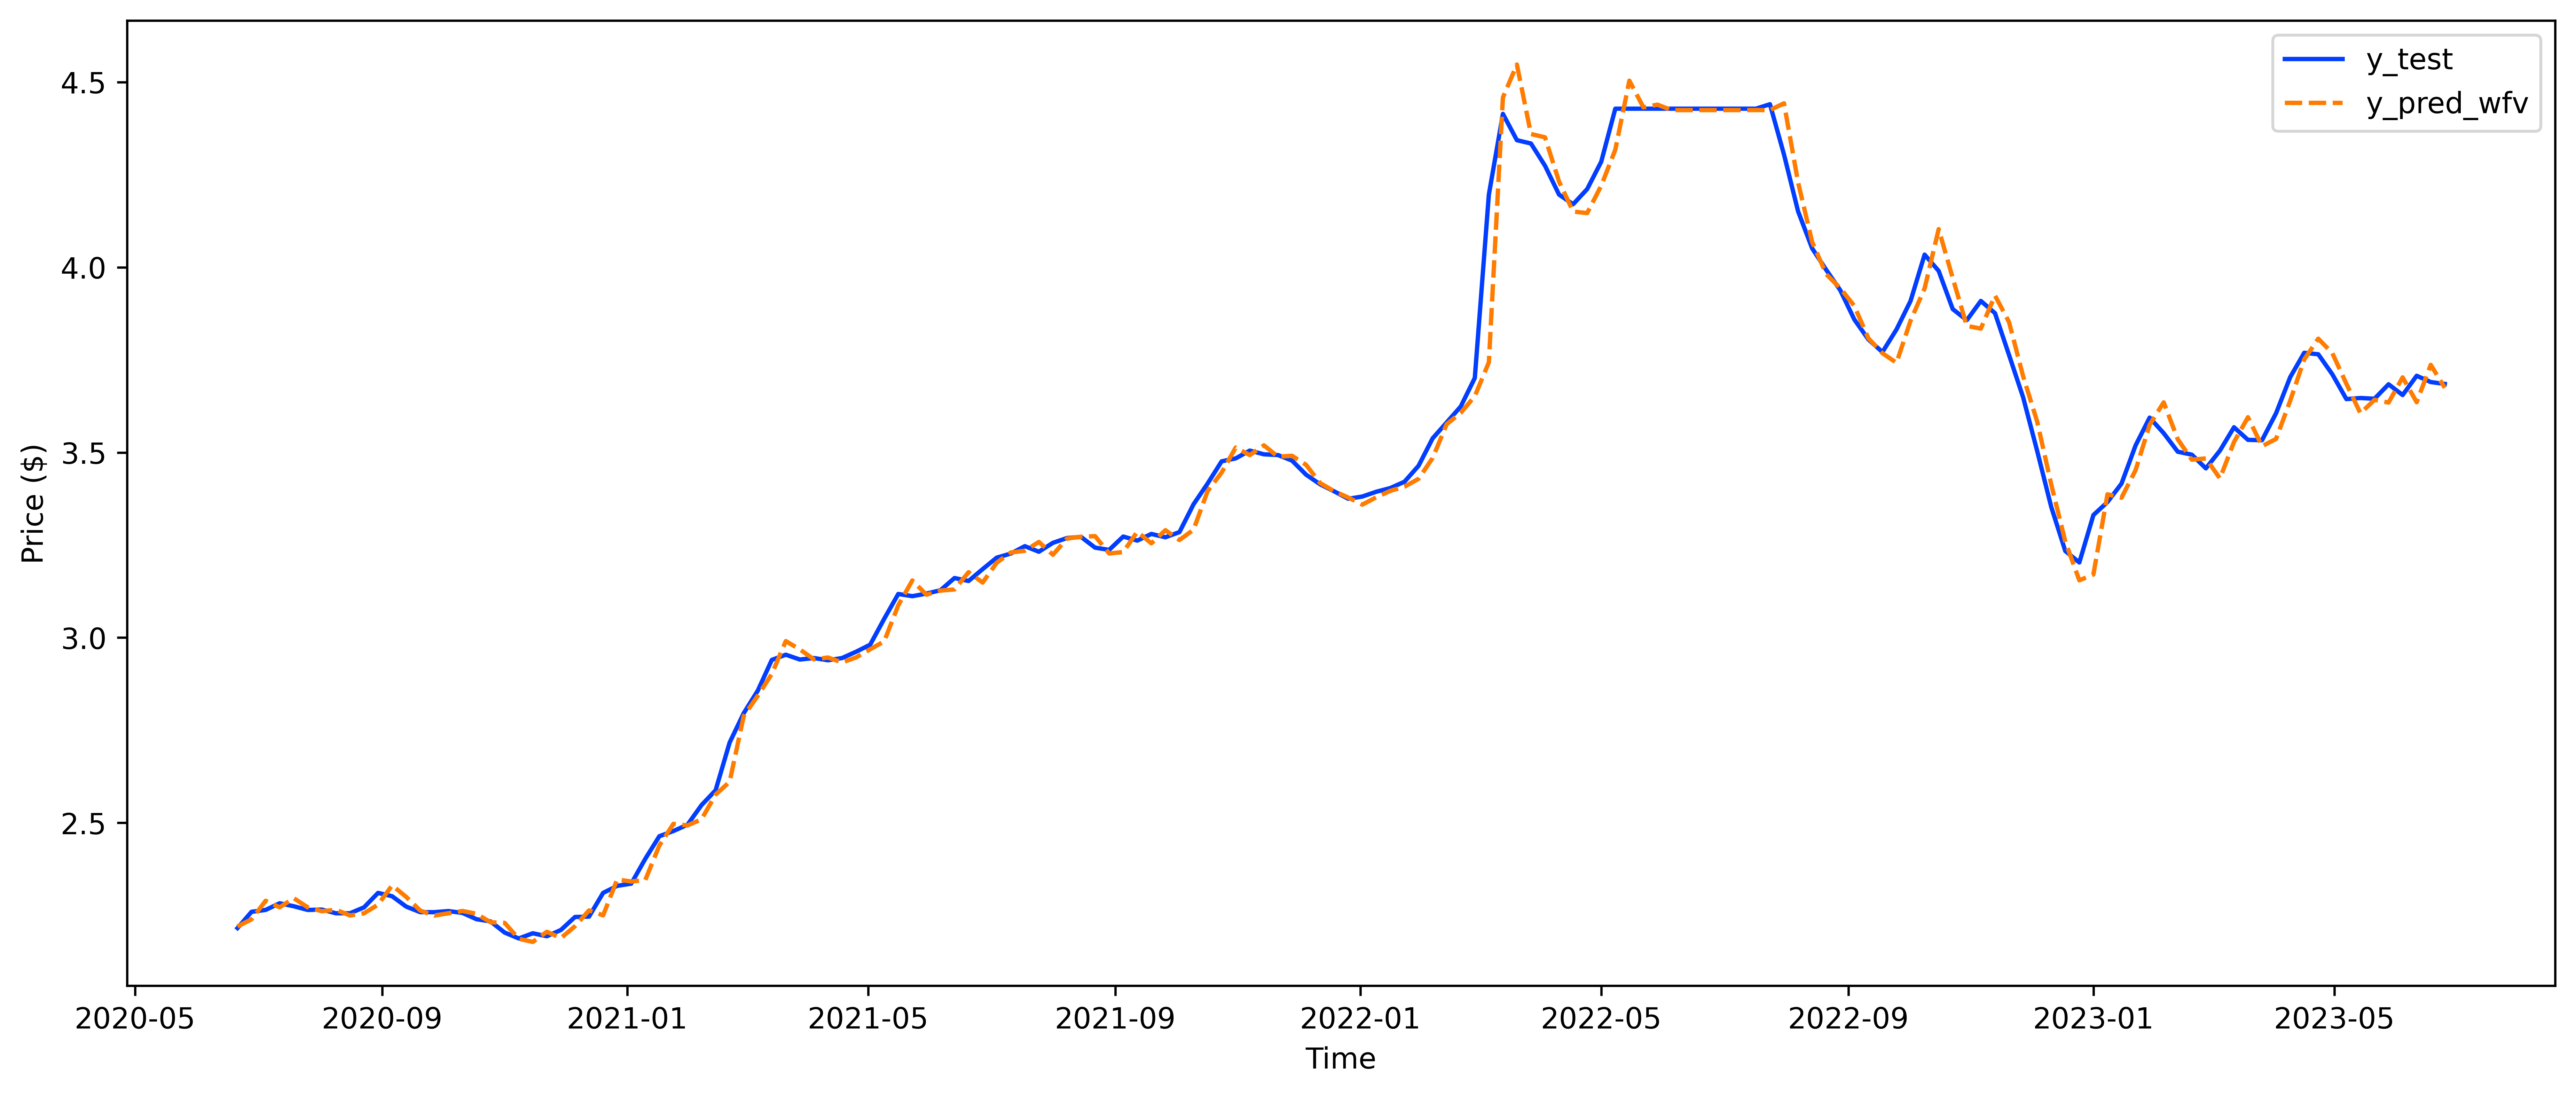

In [158]:
fig, ax =plt.subplots(dpi = 600, figsize = (15,6))
sns.lineplot(data =df_pred_wfv_test, palette = 'bright')
plt.xlabel("Time")
plt.ylabel("Price ($)");

**Conclusion:** The predicted values look great.